In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import re
import numpy as np
from tqdm import tqdm
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
MAX_WORD = 10000  # 只保留最高频的10000词
MAX_LEN = 300     # 句子统一长度为300
word_count={}     # 词-词出现的词数 词典

In [3]:
#清理文本，去标点符号，转小写
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"sssss ", " ", string)
    return string.strip().lower()
    
# 分词方法
def tokenizer(sentence):
    return sentence.split()

#  数据预处理过程
def data_process(text_path, text_dir): # 根据文本路径生成文本的标签

    print("data preprocess")
    file_pro = open(text_path,'w',encoding='utf-8')
    for root, s_dirs, _ in os.walk(text_dir): # 获取 train文件下各文件夹名称
        for sub_dir in s_dirs:
            i_dir = os.path.join(root, sub_dir)  # 获取train和test文件夹下所有的路径
            text_list = os.listdir(i_dir)
            tag = os.path.split(i_dir)[-1] # 获取标签
            if tag == 'pos':
                label = '1'
            if tag == 'neg':
                label = '0'
            if tag =='unsup':
                continue

            for i in range(len(text_list)):
                if not text_list[i].endswith('txt'): # 判断若不是txt,则跳过
                    continue
                f = open(os.path.join(i_dir, text_list[i]),'r',encoding='utf-8') # 打开文本
                raw_line = f.readline()
                pro_line = clean_str(raw_line)
                tokens = tokenizer(pro_line) # 分词统计词数
                for token in tokens:
                    if token in word_count.keys():
                        word_count[token] = word_count[token] + 1
                    else:
                        word_count[token] = 0
                file_pro.write(label + ' ' + pro_line +'\n')
                f.close()
                file_pro.flush()
    file_pro.close()

    print("build vocabulary")

    vocab = {"<UNK>": 0, "<PAD>": 1}

    word_count_sort = sorted(word_count.items(), key=lambda item : item[1], reverse=True) # 对词进行排序，过滤低频词，只取前MAX_WORD个高频词
    word_number = 1
    for word in word_count_sort:
        if word[0] not in vocab.keys():
            vocab[word[0]] = len(vocab)
            word_number += 1
        if word_number > MAX_WORD:
            break
    return vocab

In [4]:
train_dir = './data/aclImdb/train'  # 原训练集文件地址
train_path = './train.txt'  # 预处理后的训练集文件地址

test_dir = './data/aclImdb/test'  # 原训练集文件地址
test_path = './test.txt'  # 预处理后的训练集文件地址

vocab = data_process(train_path, train_dir) # 数据预处理

np.save('vocab.npy', vocab) # 词典保存为本地
vocab = np.load('vocab.npy', allow_pickle=True).item()  # 加载本地已经存储的vocab

data preprocess
build vocabulary


In [5]:
data_process(test_path, test_dir)

data preprocess
build vocabulary


{'<UNK>': 0,
 '<PAD>': 1,
 'the': 2,
 'and': 3,
 'a': 4,
 'of': 5,
 'to': 6,
 'is': 7,
 'br': 8,
 'it': 9,
 'in': 10,
 'i': 11,
 'this': 12,
 'that': 13,
 's': 14,
 'was': 15,
 'as': 16,
 'movie': 17,
 'for': 18,
 'with': 19,
 'but': 20,
 'film': 21,
 'you': 22,
 't': 23,
 'on': 24,
 'not': 25,
 'he': 26,
 'are': 27,
 'his': 28,
 'have': 29,
 'one': 30,
 'be': 31,
 'all': 32,
 'at': 33,
 'they': 34,
 'by': 35,
 'an': 36,
 'who': 37,
 'so': 38,
 'from': 39,
 'like': 40,
 'there': 41,
 'or': 42,
 'just': 43,
 'her': 44,
 'out': 45,
 'about': 46,
 'if': 47,
 'has': 48,
 'what': 49,
 'some': 50,
 'good': 51,
 'can': 52,
 'when': 53,
 'more': 54,
 'very': 55,
 'she': 56,
 'up': 57,
 'no': 58,
 'time': 59,
 'my': 60,
 'even': 61,
 'would': 62,
 'which': 63,
 'only': 64,
 'story': 65,
 'really': 66,
 'see': 67,
 'their': 68,
 'had': 69,
 'me': 70,
 'well': 71,
 'we': 72,
 'were': 73,
 'than': 74,
 'much': 75,
 'bad': 76,
 'get': 77,
 'been': 78,
 'other': 79,
 'do': 80,
 'people': 81,
 'great

In [6]:
# 定义Dataset
class MyDataset(Dataset):
    def __init__(self, text_path):
        file = open(text_path, 'r', encoding='utf-8')
        self.text_with_tag = file.readlines()  # 文本标签与内容
        file.close()

    def __getitem__(self, index): # 重写getitem
        line = self.text_with_tag[index] # 获取一个样本的标签和文本信息
        label = int(line[0]) # 标签信息
        text = line[2:-1]  # 文本信息
        return text, label

    def __len__(self):
        return len(self.text_with_tag)

In [7]:
# 定义LSTM模型
class LSTM(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_layers):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(len(vocab), embed_size) # embedding层

        self.encoder = nn.LSTM(input_size=embed_size,
                               hidden_size=num_hiddens,
                               num_layers=num_layers,
                               bidirectional=False)
        self.decoder = nn.Linear(num_hiddens, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs):
        # inputs的形状是（批量大小，词数），因此LSTM需要将序列长度（Seq_len）作为第一维，所以将输入转置后 再提取词特征
        embeddings = self.embedding(inputs.permute(1,0)) # permute(1,0)交换维度
        # LSTM只传入输入embeddings,因此只返回最后一层的隐藏层再各时间步的隐藏状态
        # outputs的形状是（词数，批量大小， 隐藏单元个数）
        outputs, _ = self.encoder(embeddings)
        # 连接初时间步和最终时间步的隐藏状态作为全连接层的输入。形状为(批量大小， 隐藏单元个数)
        encoding = outputs[-1] # 取LSTM最后一层结果
        outs = self.softmax(self.decoder(encoding)) # 输出层为二维概率[a,b]
        return outs

In [8]:
# 构建MyDataset实例
train_data = MyDataset(text_path=train_path)
test_data = MyDataset(text_path=test_path)

# 构建DataLoder
train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

In [47]:
def train(model, train_data, vocab, epoch=10):
    model = model.to(device)
    loss_sigma = 0.0
    correct = 0.0
    # 定义损失函数和优化器
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    accs_0 = []
    accs_1 = []

    for epoch in range(epoch):
        print('train model')
        model.train()
        avg_loss = 0  # 平均损失
        avg_acc = 0  # 平均准确率
        for idx, (text, label) in enumerate(train_data):

            train_x = text_transform(text, vocab).to(device)
            train_y = label.to(device)

            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred.log(), train_y)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            avg_acc += accuracy(pred, train_y)
        # 一个epoch结束后，计算平均loss和评平均acc
        avg_loss = avg_loss / len(train_data)
        avg_acc = avg_acc / len(train_data)
        avg_acc = avg_acc*100.

        print("avg_loss:", avg_loss, " train_avg_acc:", avg_acc)
        test_loss,test_acc,acc_0,acc_1 = test(model=model, test_data=test_loader, vocab=vocab)
        print("test loss:",test_loss,"total accuracy:",test_acc,"neg accuracy:",acc_0,"pos accuracy:",acc_1)
        
        train_losses.append(avg_loss)
        train_accs.append(avg_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        accs_0.append(acc_0)
        accs_1.append(acc_1)

    # 保存训练完成后的模型参数
    torch.save(model.state_dict(), 'LSTM_IMDB_parameter.pkl')
    return train_losses,train_accs,test_losses,test_accs,accs_0,accs_1

# 根据vocab将句子转为定长MAX_LEN的tensor
def text_transform(sentence_list, vocab):
    sentence_index_list = []
    for sentence in sentence_list:
        sentence_idx = [vocab[token] if token in vocab.keys() else vocab['<UNK>'] for token in tokenizer(sentence)] # 句子分词转为id

        if len(sentence_idx) < MAX_LEN:
            for i in range(MAX_LEN-len(sentence_idx)): # 对长度不够的句子进行PAD填充
                sentence_idx.append(vocab['<PAD>'])

        sentence_idx = sentence_idx[:MAX_LEN] # 取前MAX_LEN长度
        sentence_index_list.append(sentence_idx)
    return torch.LongTensor(sentence_index_list) # 将转为idx的词转为tensor
# 模型测试
def test(model, test_data, vocab):
    print('test model')
    model = model.to(device)
    model.eval()
    
    sum_0=0
    sum_1=0
    correct_0=0
    correct_1=0
    total = 0
    correct =0
    
    criterion = torch.nn.NLLLoss()
    running_loss = 0.0
    
    for idx, (text, label) in enumerate(test_data):
        test_x = text_transform(text, vocab).to(device)
        test_y = label.to(device)
        pred = model(test_x)
        
        loss = criterion(pred.log(), test_y)        
        running_loss += loss.item()
        
        _, predicted = pred.max(1)
        total += test_y.size(0)
        correct += predicted.eq(test_y).sum().item()
        
        label_pred = pred.max(dim=1)[1]
        for i in range(len(test_y)):
            if(test_y[i] == 0):
                sum_0 += 1
                if(label_pred[i] == 0):
                    correct_0 += 1
            elif(test_y[i] == 1):
                sum_1 += 1
                if(label_pred[i] == 1):
                    correct_1 += 1       
        correct=correct_0+correct_1

    test_loss = running_loss / len(test_data)
    test_acc = 100.*correct/total
    acc_0 = 100. * correct_0 / sum_0
    acc_1 = 100. * correct_1 / sum_1
    return test_loss,test_acc,acc_0,acc_1

# 计算预测准确性
def accuracy(y_pred, y_true):
    label_pred = y_pred.max(dim=1)[1]
    acc = len(y_pred) - torch.sum(torch.abs(label_pred-y_true)) # 正确的个数
    return acc.detach().cpu().numpy() / len(y_pred)

In [52]:
model = LSTM(vocab=vocab, embed_size=300, num_hiddens=128, num_layers=2)  # 定义模型

train_losses,train_accs,test_losses,test_accs,accs_0,accs_1=train(model=model, train_data=train_loader, vocab=vocab, epoch=20)

train model
avg_loss: 0.6952711860744321  train_avg_acc: 51.1025950558795
test model
test loss: 0.6905221952806653 total accuracy: 51.62 neg accuracy: 83.032 pos accuracy: 20.208
train model
avg_loss: 0.6717954697657604  train_avg_acc: 54.2680241739553
test model
test loss: 0.6943459713550479 total accuracy: 52.612 neg accuracy: 90.384 pos accuracy: 14.84
train model
avg_loss: 0.5765463211098496  train_avg_acc: 65.81746537900874
test model
test loss: 0.548748932454897 total accuracy: 74.268 neg accuracy: 80.64 pos accuracy: 67.896
train model
avg_loss: 0.4235331851000689  train_avg_acc: 81.23063957725948
test model
test loss: 0.5641671052140653 total accuracy: 72.74 neg accuracy: 63.848 pos accuracy: 81.632
train model
avg_loss: 0.31254672669634526  train_avg_acc: 87.26482780612244
test model
test loss: 0.4877047239971893 total accuracy: 80.752 neg accuracy: 80.488 pos accuracy: 81.016
train model
avg_loss: 0.23953177247728621  train_avg_acc: 90.7151588313897
test model
test loss: 0.49

In [53]:
import pandas as pd
result=pd.DataFrame()
result['train_losses']=train_losses
result['train_accs']=train_accs
result['test_losses']=test_losses
result['test_accs']=test_accs
result['accs_0']=accs_0
result['accs_1']=accs_1

In [54]:
result

,train_losses,train_accs,test_losses,test_accs,accs_0,accs_1
0,0.695271,51.102595,0.690522,51.620,83.032,20.208
1,0.671795,54.268024,0.694346,52.612,90.384,14.840
2,0.576546,65.817465,0.548749,74.268,80.640,67.896
3,0.423533,81.230640,0.564167,72.740,63.848,81.632
4,0.312547,87.264828,0.487705,80.752,80.488,81.016
5,0.239532,90.715159,0.494244,82.096,78.744,85.448
6,0.170903,93.578224,0.531815,82.496,79.856,85.136
7,0.141980,94.749150,0.558563,82.192,80.024,84.360
8,0.117137,95.861805,0.609092,82.312,77.768,86.856
9,0.086857,97.081511,0.629664,82.352,80.616,84.088


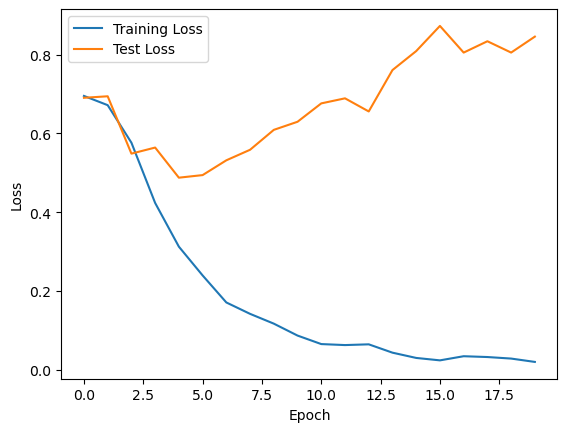

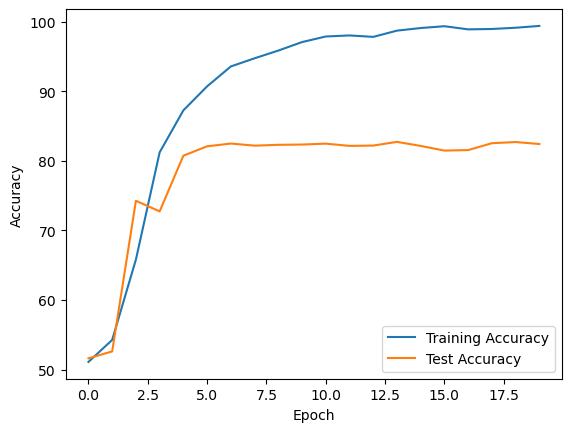

In [55]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()